## A3. Community detection

### INFO

#### TASKS: 


[1] Apply at least three different community detection algorithms for the attached undirected networks

[2] At least one of the algorithms must be based on the optimization of modularity

[3] You must use at least two different programs

#### Comparissons: 
[1] Partition of reference, obtained from external information. In these cases, you have to compare your partitions with them, using at least the following standard measures: Jaccard Index, Normalized Mutual Information (arithmetic normalization), and Normalized Variation of Information.

#### DELIVERY
[1] a plot with color-coded communities

[2] Brief description of the algorithms and the programs used.

[3] Selected parameters for each algorithm and/or network, and the scripts used (if any).

[4] A table with the comparison measures between your partitions and the reference ones, grouped by network.

[5] A table with the modularity values of all the partitions (including the reference ones), grouped by network.

[6] The obtained partitions, in Pajek format (*.clu)



#### CAVEATS: 
[1] The position of the nodes must not change for all the partitions of the same network.

[2] If the network contains coordinates for the nodes (e.g. airports_UW.net), use them to establish the position of the nodes. Otherwise, use a layout algorithm to distribute the nodes in the plane trying to minimize the number of links crossings (e.g., Kamada-Kawai, ForceAtlas, etc.). Circular layouts must not be used.



## Community 

- Groups of densely connected components in various networks. 
- Most widely used algorithm Girvan-Newman algorithm

#### Techniques 
- **Agglomerative**: start only with the nodes of the original graph. Edges are added in a specific manner, if they have a weight, stronger ones are prioritized over weaker ones. 

- **Divisive**: Remove edges from the original graph iteratively. Stronger edges are removed before weaker ones. 

### Imports & Settings

In [1]:
## get the community module 
!pip3 install -qq python-louvain

In [2]:
## import libraries 
import numpy as np 
import glob 
import networkx as nx 
import matplotlib.pyplot as plt
from community import community_louvain

In [3]:
## paths to the model, real and toy data ## *.clu format is PAJEK format
MODEL_DATA = './data/model/'
REAL_DATA = './data/real/'
TOY_DATA = './data/toy/'

## get all the files in each directory 
## model
model_files = glob.glob(MODEL_DATA+"/*")
## real 
real_files = glob.glob(REAL_DATA+"/*")
## toy 
toy_files = glob.glob(TOY_DATA+"/*")

#### Code

#### Community Detection Algorithm 1: Girvan-Newman algorithm

https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.centrality.girvan_newman.html#networkx.algorithms.community.centrality.girvan_newman

- Divisive method, progressively removes edges from the original graph. 
- Removes the "most-valuable" edge. 
    - Highest betweenness centrality.
        - Highest number of shortest paths between nodes. 
        - definition is unclear but something as: 
            Number of shortest paths through V or E / Total shortest paths
- Result can be shown as a dendrogram. 

./data/toy/20x2+5x2.net
20x2+5x2.net


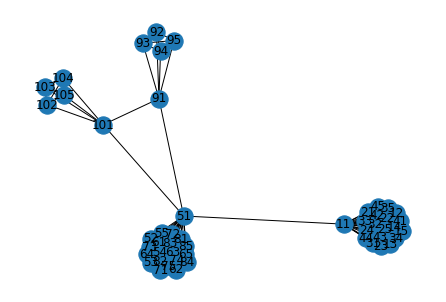

In [21]:
## import
from networkx.algorithms.community.centrality import girvan_newman
## load a sample graph from the toy_files 
print(toy_files[3])
sample = toy_files[3]
## print the name of the file 
print(sample.split("/")[-1])
## read the file into nx 
g = nx.read_pajek(sample)
## draw the graph 
nx.draw(g, with_labels=True)

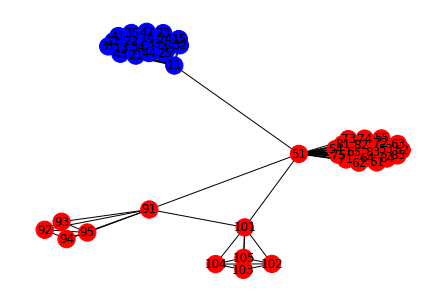

20
30


In [22]:
## apply the algorithm to the graph 
communities = girvan_newman(g) ## generator object 
## get the nodes belonging to the first community
node_groups = [com for com in next(communities)]
## loop over the nodes in the original graph 
## if they are the original assign a color to them
c1 = 'red'
c2 = 'blue'
color_map = [c2 if node in node_groups[0] else c1  for node in g.nodes()]
## draw it again 
nx.draw(g, node_color=color_map, with_labels=True)
plt.show()
## the first community is the largest one
for groups in node_groups:
    print(len(groups))

In [23]:
## another approach to get the community
import itertools 
## define the number of communities (tuple)
k = 5
for comm in itertools.islice(communities, k):
    print(tuple(sorted(c) for c in comm))

(['11', '12', '13', '14', '15', '21', '22', '23', '24', '25', '31', '32', '33', '34', '35', '41', '42', '43', '44', '45'], ['51', '52', '53', '54', '55', '61', '62', '63', '64', '65', '71', '72', '73', '74', '75', '81', '82', '83', '84', '85'], ['101', '102', '103', '104', '105', '91', '92', '93', '94', '95'])
(['11', '12', '13', '14', '15', '21', '22', '23', '24', '25', '31', '32', '33', '34', '35', '41', '42', '43', '44', '45'], ['51', '52', '53', '54', '55', '61', '62', '63', '64', '65', '71', '72', '73', '74', '75', '81', '82', '83', '84', '85'], ['91', '92', '93', '94', '95'], ['101', '102', '103', '104', '105'])
(['11'], ['12', '13', '14', '15', '21', '22', '23', '24', '25', '31', '32', '33', '34', '35', '41', '42', '43', '44', '45'], ['51', '52', '53', '54', '55', '61', '62', '63', '64', '65', '71', '72', '73', '74', '75', '81', '82', '83', '84', '85'], ['91', '92', '93', '94', '95'], ['101', '102', '103', '104', '105'])
(['11'], ['12'], ['13', '14', '15', '21', '22', '23', '24'

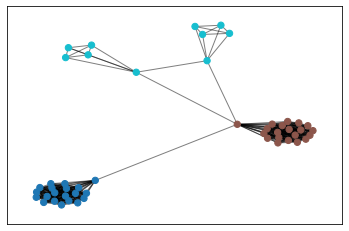

In [24]:
## using another package 
from community import community_louvain
import matplotlib.cm as cm

# compute the best partition
partition = community_louvain.best_partition(g)

# draw the graph
pos = nx.spring_layout(g)
# color the nodes according to their partition
cmap = cm.get_cmap('tab10', max(partition.values()) + 1)
## draw the nodes
nx.draw_networkx_nodes(g, pos, partition.keys(), node_size=40,
                       cmap=cmap, node_color=list(partition.values()))
## draw the edges 
nx.draw_networkx_edges(g, pos, alpha=0.5)
plt.show()

#### Community Detection Algorithm 2: Fluid Communities algorithm

https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.centrality.girvan_newman.html#networkx.algorithms.community.centrality.girvan_newman


Very nice graphs 
https://arxiv.org/pdf/1703.09307.pdf

- Based on "fluids interacting with each other" 
    - expanding and pushing each other. 

Mechanics: 
- Initial k communities initialized on a random vertex. 
- Iterate over all vertices in random order. 
- **Vertex move from one place to the other, different densities, shifts**


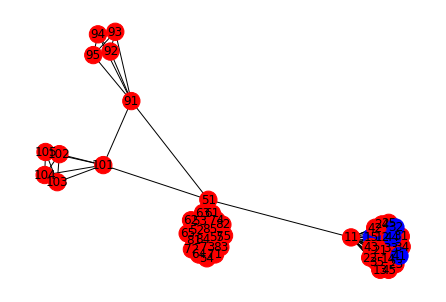

In [83]:
## import 
from networkx.algorithms.community import asyn_fluid
## set parameters 
## K is the number of communities
K = 5
## max_iter is the maximum number of iterations
max_iter = 100
## assign fluids 
fluids = asyn_fluid.asyn_fluidc(G=g, k=K, max_iter=max_iter)
## iterate over the fluids and print the communities
cmms = [fluid for fluid in fluids]
color_map = [c2 if node in cmms[0] else c1  for node in g.nodes()]

## assign a color to each community
for comm in itertools.islice(fluids, k):
    print(tuple(sorted(c) for c in comm))
    
## drawing the graph
nx.draw(g, node_color=color_map, with_labels=True)

#### Community Detection Algorithm 3: Label Propagation algorithm

#### Community Detection Algorithm 4: Label Propagation algorithm

#### Community Detection Algorithm 5: Clique Percolation algorithm

#### Community Detection Algorithm 6: Kernighan-Lin algorithm